## **Readme**

##### Mask has been the new norm in 2020 worldwide, the correct way to wear masks is to cover both nose and mouth. Wearing mask incorrectly gives one an false impression that he is protecting against covid-19. The purpose of this notebook is to build an image classification model to detect if the subject in the image worn his mask correct.

## **About the project**
##### Title: Mask Detection
Author: Huang Xiaoling

## **3 models were built:**
1. Base model using VGG architecture (without transfer learning)
2. Using VGG architecture with transfer learning
3. Using SVM as the classification (instead of softmax) using NASNet

## **Result:**
##### The models were evaluated based on their accuracy. The model with the best weights were saved for later prediction.
1. Accuracy of base model = 98.477%
2. Accuracy of model with transfer learning = 98.58%
3. Accuracy of model with SVM = 83.9%

## **Data**
##### The data used in this notebook can be found in this link (https://github.com/cabani/MaskedFace-Net).

## **Citation**
1. Adnane Cabani, Karim Hammoudi, Halim Benhabiles, and Mahmoud Melkemi, "MaskedFace-Net - A dataset of correctly/incorrectly masked face images in the context of COVID-19", Smart Health, ISSN 2352-6483, Elsevier, 2020, DOI:10.1016/j.smhl.2020.100144
2. Karim Hammoudi, Adnane Cabani, Halim Benhabiles, and Mahmoud Melkemi,"Validating the correct wearing of protection mask by taking a selfie: design of a mobile application "CheckYourMask" to limit the spread of COVID-19", CMES-Computer Modeling in Engineering & Sciences, Vol.124, No.3, pp. 1049-1059, 2020, DOI:10.32604/cmes.2020.011663

In [ ]:
#https://github.com/cabani/MaskedFace-Net
!nvidia-smi

Sun Jan  3 07:57:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls

drive  sample_data


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np
import time
from IPython.display import Image

## **User-Defined Functions**

In [ ]:
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

In [ ]:
def image_to_input(model, img_path):
    target_size=model.input_shape[1:]
    img = image.load_img(img_path, target_size=target_size)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

In [ ]:
def get_single_prediction(img_path, top=5):
    x = image_to_input(model_imagenet, img_path)
    preds = model_imagenet.predict(x)
    predictions = decode_predictions(preds, top=top)
    return predictions[0]

## **Load data and pre-processing**

In [ ]:
#https://www.dropbox.com/s/1o2i30bgmvzmxmh/Facemask.zip
!wget -qq https://www.dropbox.com/s/1o2i30bgmvzmxmh/Facemask.zip
!unzip -qq Facemask.zip
!rm Facemask.zip
#!rm -r __MACOSX

!ls

drive  Facemask  sample_data


In [ ]:
!ls Facemask

correct  incorrect


In [ ]:
path = "./Facemask/"

#img_width, img_height = 224, 224

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
#df['class'] = df['class_name'].cat.codes
df["class"] = np.where(df["class_name"].str.contains("incorrect"), 0, 1)

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head(10))
print(len(df))
df.dtypes

                                            filename class_name  class
0           /content/Facemask/correct/14845_Mask.jpg    correct      1
1  /content/Facemask/incorrect/59534_Mask_Mouth_C...  incorrect      0
2  /content/Facemask/incorrect/23371_Mask_Mouth_C...  incorrect      0
3           /content/Facemask/correct/14251_Mask.jpg    correct      1
4           /content/Facemask/correct/69302_Mask.jpg    correct      1
5  /content/Facemask/incorrect/08192_Mask_Mouth_C...  incorrect      0
6           /content/Facemask/correct/69460_Mask.jpg    correct      1
7           /content/Facemask/correct/00144_Mask.jpg    correct      1
8  /content/Facemask/incorrect/46428_Mask_Mouth_C...  incorrect      0
9           /content/Facemask/correct/42768_Mask.jpg    correct      1
9546


filename        object
class_name    category
class            int64
dtype: object

In [ ]:
# Split into train and validation sets
train_set_percentage = .8


df_train = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

print(df_train.shape, df_val.shape)

(7636, 3) (1910, 3)


In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
num_classes = 2
batch_size = 16

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
# valid_dataset = valid_dataset
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

## **Base Model**

In [ ]:
# create the base pre-trained model
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3),pooling=None)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='sigmoid')(x)

In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dense_1  Trainable = True


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=0,mode='auto')

!mkdir checkpoints
!ls

checkpoint = ModelCheckpoint('./checkpoints/best_weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

checkpoints  drive  Facemask  sample_data


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_steps = int(7636/batch_size) #total trains set / batch_size
val_steps = int(1910/batch_size)
epochs = 10

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 477
val steps: 119


In [ ]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                    callbacks=[checkpoint])

Epoch 1/10
477/477 [==============================] - 140s 212ms/step - loss: 0.5439 - accuracy: 0.8955 - val_loss: 0.1520 - val_accuracy: 0.9501

Epoch 00001: val_accuracy improved from -inf to 0.95011, saving model to ./checkpoints/best_weights.hdf5
Epoch 2/10
477/477 [==============================] - 98s 206ms/step - loss: 0.0778 - accuracy: 0.9752 - val_loss: 0.0897 - val_accuracy: 0.9764

Epoch 00002: val_accuracy improved from 0.95011 to 0.97637, saving model to ./checkpoints/best_weights.hdf5
Epoch 3/10
477/477 [==============================] - 95s 200ms/step - loss: 0.0625 - accuracy: 0.9799 - val_loss: 0.0776 - val_accuracy: 0.9758

Epoch 00003: val_accuracy did not improve from 0.97637
Epoch 4/10
477/477 [==============================] - 96s 202ms/step - loss: 0.0434 - accuracy: 0.9853 - val_loss: 0.0909 - val_accuracy: 0.9743

Epoch 00004: val_accuracy did not improve from 0.97637
Epoch 5/10
477/477 [==============================] - 97s 204ms/step - loss: 0.0322 - accura

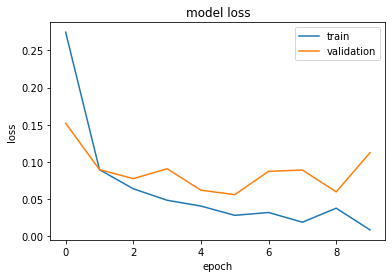

In [ ]:
plot_train(history)

In [ ]:
model.load_weights('./checkpoints/best_weights.hdf5')

In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

119/119 [==============================] - 19s 163ms/step - loss: 0.0561 - accuracy: 0.9848
model accuracy: 0.9847689270973206


test1.jpg


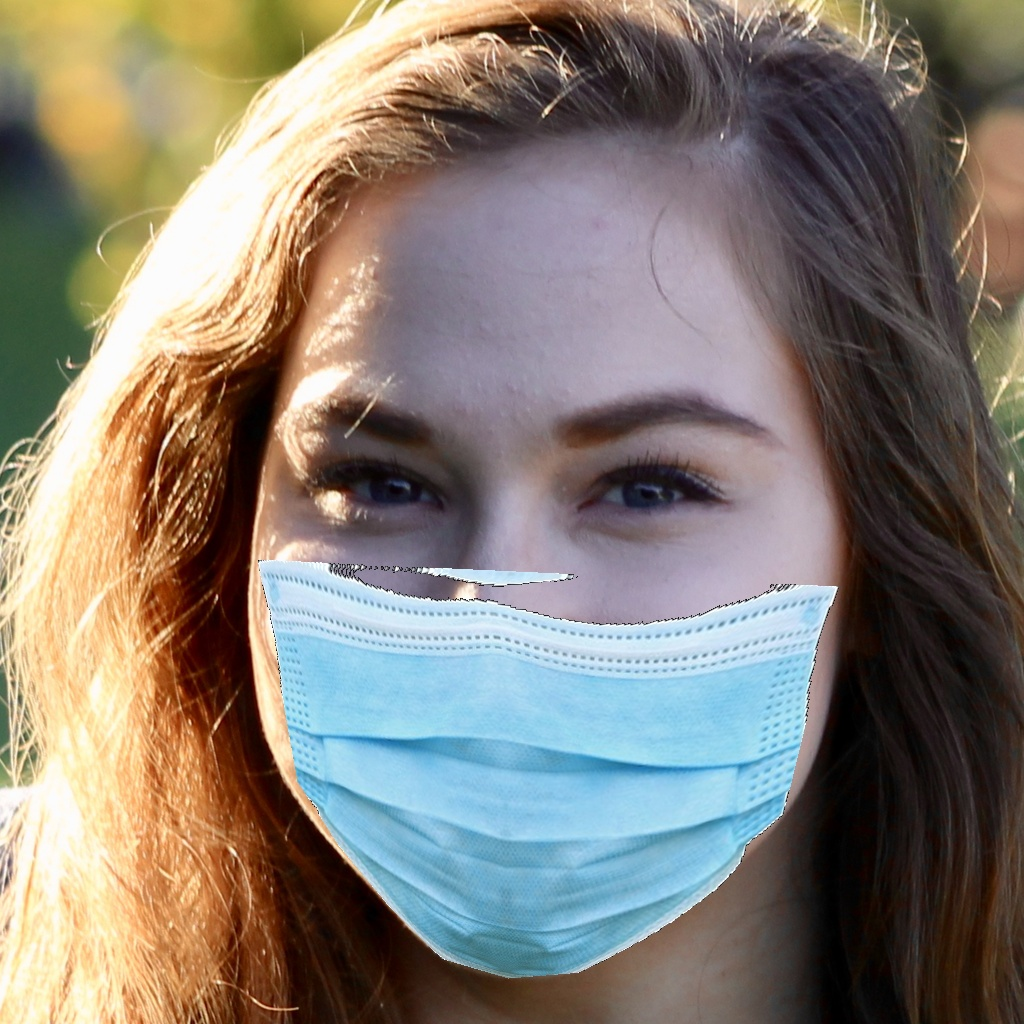

In [ ]:
img_path = os.path.join( 'test1.jpg')
#img_path = os.path.join(image_path, image_check)
print(img_path)

#img = image.load_img(img_path, target_size=(224, 224))
x = image_to_input(model, img_path)
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)
#print('Input image shape:', x.shape)

Image(img_path)

In [ ]:
preds = model.predict(x)
print('Predicted:', preds)

result= preds[0][0]
if result< preds[0][1]:
    print("Perfect, the mask is worn correctly!")
else:
    print("The mask is worn incorrectly :(")

Predicted: [[0.06367915 0.95300895]]
Perfect, the mask is worn correctly!


Input image shape: (1, 224, 224, 3)


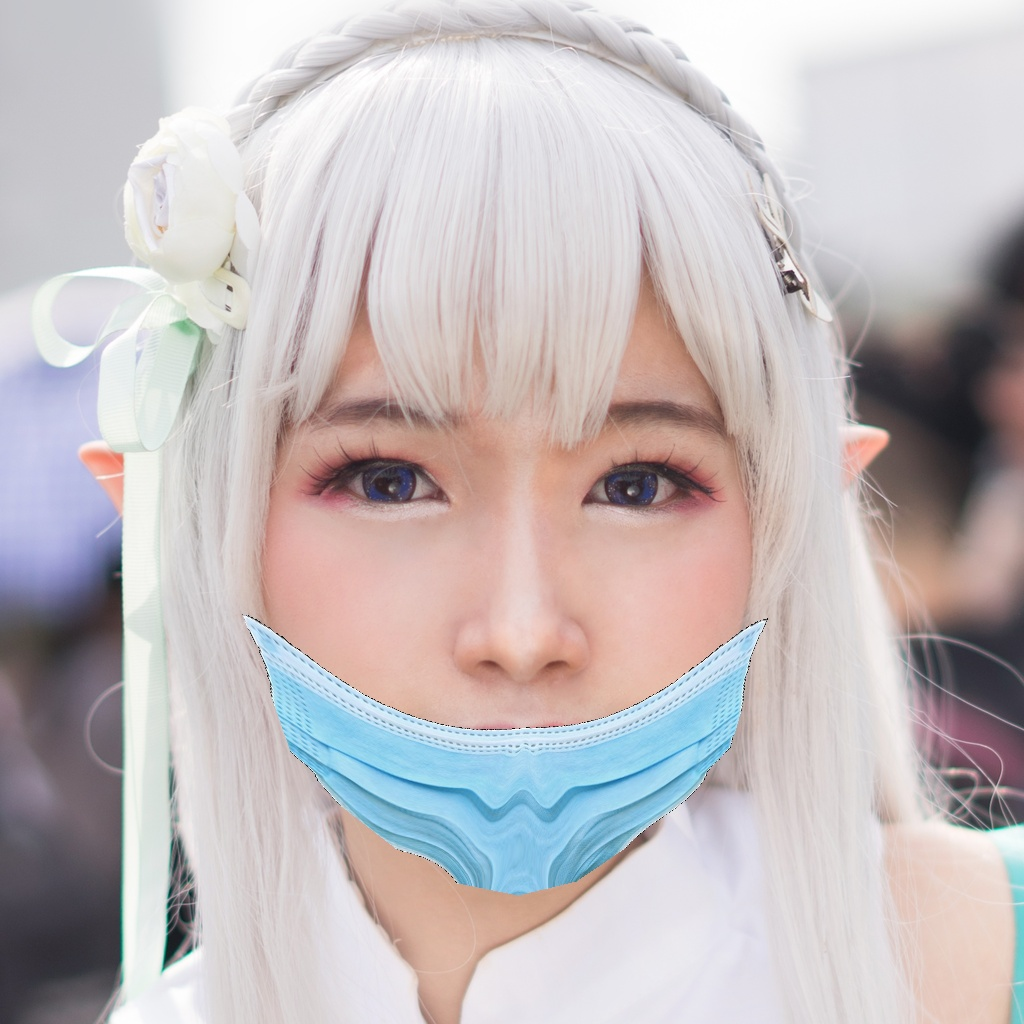

In [ ]:
img_path = os.path.join( 'test2.jpg')
#img_path = os.path.join(image_path, image_check)
#print(img_path)

#img = image.load_img(img_path, target_size=(224, 224))
x = image_to_input(model, img_path)
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)
print('Input image shape:', x.shape)

Image(img_path)

In [ ]:
preds = model.predict(x)
print('Predicted:', preds)

result= preds[0][0]
if result< preds[0][1]:
    print("Perfect, the mask is worn correctly!")
else:
    print("The mask is worn incorrectly :(")

Predicted: [[0.99856156 0.00563291]]
The mask is worn incorrectly :(


## **Transfer Learning & Fine Tuning**

In [ ]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d True
dense True
dense_1 True


In [ ]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                    callbacks=[checkpoint])

Epoch 1/10
477/477 [==============================] - 126s 199ms/step - loss: 0.0463 - accuracy: 0.9858 - val_loss: 0.0868 - val_accuracy: 0.9743

Epoch 00001: val_accuracy did not improve from 0.98477
Epoch 2/10
477/477 [==============================] - 96s 201ms/step - loss: 0.0394 - accuracy: 0.9849 - val_loss: 0.0727 - val_accuracy: 0.9753

Epoch 00002: val_accuracy did not improve from 0.98477
Epoch 3/10
477/477 [==============================] - 96s 201ms/step - loss: 0.0111 - accuracy: 0.9959 - val_loss: 0.0558 - val_accuracy: 0.9858

Epoch 00003: val_accuracy improved from 0.98477 to 0.98582, saving model to ./checkpoints/best_weights.hdf5
Epoch 4/10
477/477 [==============================] - 96s 202ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0736 - val_accuracy: 0.9832

Epoch 00004: val_accuracy did not improve from 0.98582
Epoch 5/10
477/477 [==============================] - 98s 206ms/step - loss: 0.0193 - accuracy: 0.9924 - val_loss: 0.0702 - val_accuracy: 0.98

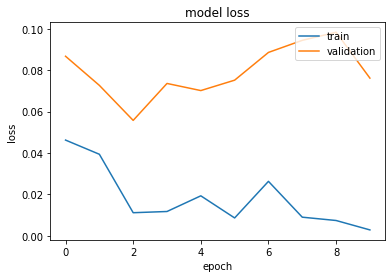

In [ ]:
plot_train(history)

In [ ]:
model.load_weights('./checkpoints/best_weights.hdf5')

In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

119/119 [==============================] - 19s 163ms/step - loss: 0.0558 - accuracy: 0.9858
model accuracy: 0.9858193397521973


## **Top with SVM with Network as features**


In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input, decode_predictions

model_imagenet = NASNetMobile(weights='imagenet', include_top=True)   # 24,227,760 bytes
print("Model Loaded")

24231936/24227760 [==============================] - 0s 0us/step
Model Loaded


In [ ]:
#image_dir = './images/'

#path = "./Facemask"
image_files = df_train["filename"].tolist()

t0 = time.time()
for i, f in enumerate(image_files):
    im = plt.imread(f)
    if not (im.shape[0]==224 and im.shape[1]==224):
        continue
    
    plt.figure()
    plt.imshow(im.astype('uint8'))
    
    top5 = get_single_prediction(f)
    for n, (id,label,prob) in enumerate(top5):
        plt.text(350, 50 + n * 25, '{}. {}'.format(n+1, label), fontsize=14)
    plt.axis('off')
        
print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(image_files),))

DONE :   0.02 seconds each


In [ ]:
model_imagenet.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [ ]:
logits_layer = model_imagenet.get_layer('predictions')
model_logits = Model(inputs=model_imagenet.input, 
                           outputs=logits_layer.output)
print("Model Loaded")

Model Loaded


In [ ]:
def get_logits_from_non_top(np_logits):
    # ~ average pooling
    #return np_logits[0].sum(axis=0).sum(axis=0)
    
    # ~ max-pooling
    return np_logits[0].max(axis=0).max(axis=0)

In [ ]:
classes = sorted( [ d for d in os.listdir(path) 
                    if os.path.isdir(os.path.join(path, d)) ] )
classes # Sorted for for consistency

['correct', 'incorrect']

In [ ]:
train = dict(filepath=[], features=[], target=[])

t0 = time.time()

for class_i, directory in enumerate(classes):
    for filename in os.listdir(os.path.join(path, directory)):
        filepath = os.path.join(path, directory, filename)
        if os.path.isdir(filepath): continue

        im_sq = plt.imread(filepath)
 #       im_sq = crop_middle_square_area(im)

        x = image_to_input(model_logits, filepath)
        #np_logits = model_logits.predict(x)  # Shape = 1x7x7x1056  if pooling=None
        #print(np_logits.shape)
        #np_logits_pooled = get_logits_from_non_top( np_logits )
        
        np_logits_pooled = model_logits.predict(x)[0]  # Shape = 1x1056 if pooling=avg
        
        train['filepath'].append(filepath)
        train['features'].append(np_logits_pooled)
        train['target'].append( class_i )

  #      plt.figure()
  #      plt.imshow(im_sq.astype('uint8'))
  #      plt.axis('off')

  #      plt.text(2*320, 50, '{}'.format(filename), fontsize=14)
  #      plt.text(2*320, 80, 'Train as class "{}"'.format(directory), fontsize=12)

print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(train),))

DONE : 251.83 seconds each


In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

classifier = svm.LinearSVC()
classifier.fit(train['features'], train['target']) # learn from the data 
scores = cross_val_score(classifier, train['features'], train['target'], cv=5)
print('The accuracy of each fold is:', scores)

The accuracy of each fold is: [0.83246073 0.83918282 0.83813515 0.82294395 0.82294395]


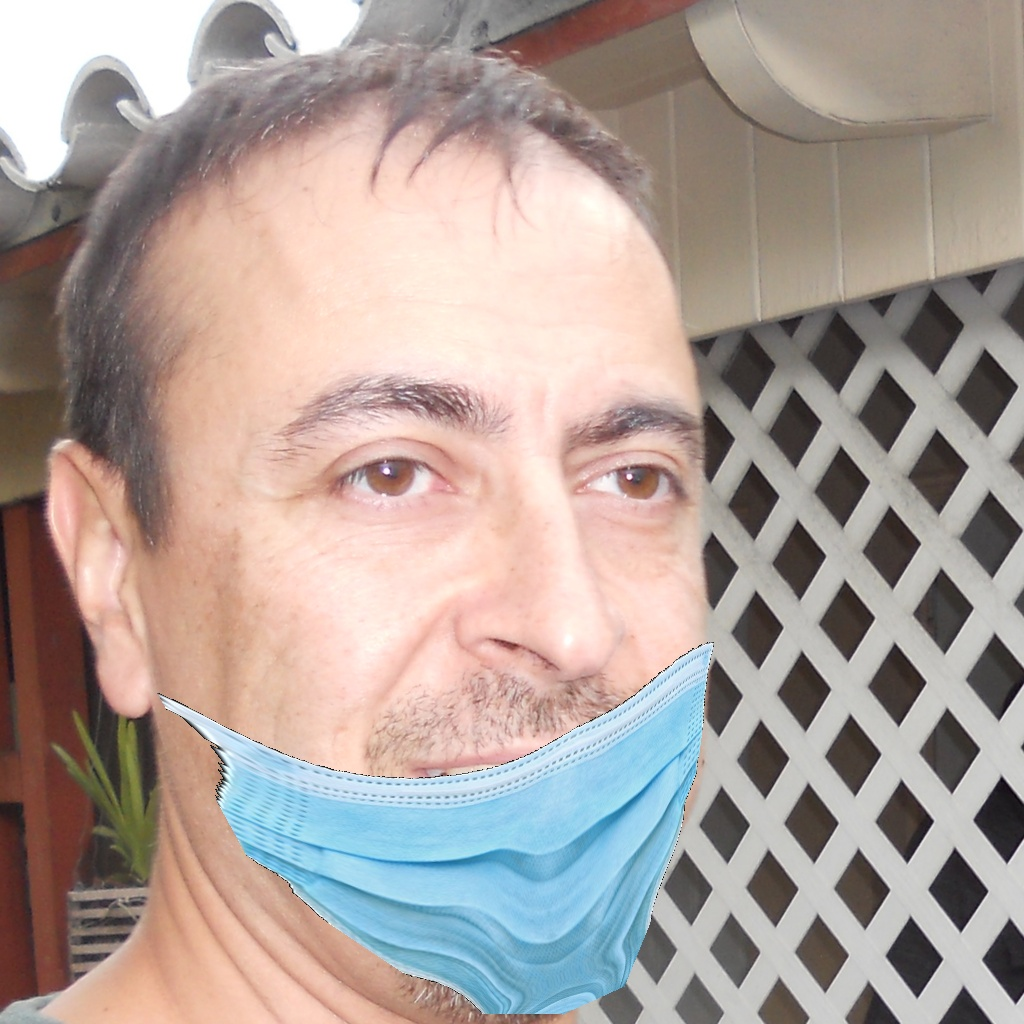

In [ ]:
img_path = os.path.join( 'test3.jpg')
im_sq = plt.imread(img_path)
#    im_sq = crop_middle_square_area(im)

    # This is two ops : one merely loads the image from numpy, 
    #   the other runs the network to get the class probabilities
x = image_to_input(model_logits, filepath)
    #np_logits = model_logits.predict(x)  # Shape = 1x7x7x1056
    #np_logits_pooled = get_logits_from_non_top( np_logits )
    
np_logits_pooled = model_logits.predict(x)[0]  # Shape = 1x1056

prediction_i = classifier.predict([ np_logits_pooled ])
decision     = classifier.decision_function([ np_logits_pooled ])

 #   plt.figure()
 #   plt.imshow(im_sq.astype('uint8'))
 #   plt.axis('off')
Image(img_path)


In [ ]:
prediction = classes[ prediction_i[0] ]
print(prediction)
  #  plt.text(2*320, 50, '{} : Distance from boundary = {:5.2f}'.format(prediction, decision[0]), fontsize=20)
  #  plt.text(2*320, 75, '{}'.format(filename), fontsize=14)

print("DONE : %6.2f seconds each" %(float(time.time() - t0),))

incorrect
DONE : 1670.24 seconds each
